
\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#
#     Subject: NLP Assignment 2       # 
##     Student Name: Nirmal Pregassame
##     Student ID:  R00181587
\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#

This notebook is done in Google Colab and represents the work which has been done to complete the Assignment 2 of NLP. The aim of the assignment is to work on dataset in order to train our model for commonsense reasoning. The assignment is divided in 3 parts:
1. Part 1 : Detectection of nonsense sentences
1. Part 2 : Finding the key reason of the nonsense of a sentence
1. Part 3 : Generating the reason for a nonsense sentence

# Part 1

In this part we will try to detect the sentence which does not make sense. For that, we will use a pretrained BERT (Biderectional Encoder Representations from Transformers) which is widely used to process text in comparison to the classical VGG16 with the Imagenet dataset (which more dedicated to image classification).

To start, we will load the 1st dataset which will be used to train our BERT model. The dataset has a dimension of 10,000x2: We have indeed 10,000 lines of 2 and we have to determine which sentence among the 2 does not make sense.

The dataset is present in csv format. The subTaskA_data_all.csv has 3 columns:
* *id*: The data id
* *sent0*: The 1st sentence
* *sent1*: The 2nd sentence

The subTaskA_answer_all.csv has 2 columns:
* *id*: The data id
* *result*: The result; the sentence which does not make sense.

In our programme, we will load those csv files in dataframe format.


In [0]:
from google.colab import drive
import pandas as pd
import numpy as np
import io

# Disk mount
drive.mount('/content/drive')

# Load the csv files of the data as well as of the results into df format
df_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP_Assignment_2/Training  Data/Training  Data/subtaskA_data_all.csv', index_col='id', names=['id', 'sent0', 'sent1'], skiprows=1 )
df_result = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP_Assignment_2/Training  Data/Training  Data/subtaskA_answers_all.csv', index_col='id', names=['id', 'result'])


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Data Preparation

In this phase, we will install the pretrained bert which will serve for our model building and we also transform the dataset to get vectors the data and labels . 

In [0]:
# Pretrained bert installation
pip install pytorch_pretrained_bert

     |████████████████████████████████| 133kB 5.1MB/s 
     |████████████████████████████████| 645kB 16.1MB/s 


In [0]:
from pytorch_pretrained_bert import BertTokenizer, BertConfig

# We set the bert tokenizer: The tokenizer is case insensitive. Indeed we just need to see if the sentence makes sense or not.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 1237694.85B/s]


In the code below, we are preparing and tranforming the dataset for our model inputs. Indeed, the senences in the data cannot be used as it is. We should:
1. Determine the non-sense sentence and the sense: We use the value in the answer table.
1. Tokenize the sentence: During the process, we can note below that we use special symboles to use as a separator. Typically, for the begining of a sentence use '[CLS]' and for the end , we use '[SEP]'.
1. Convert each tokens into ids: This id is used to identified each tokens
1. The processed sentence has to be appended in a list. The labels is also appended into another list.

In [0]:
# training_set will be our input vector of data containing tokenized sentence
training_set = []
# label_set will be our input vector of label containing the value (1 or 0): 1 is the non-sense sentence and 0 the sense sentence
label_set = []

# max sentence lenght from our dataset
max_len =0

#The loop will go through each line (10,000 lines) and store the data and labels in their respective vectors 
for i in df_result.index.tolist():

  # Non-sense sentence values coming from the label dataset 
  nonsense_sentence = df_result.values[i][0]

  # Store the sense and non-sense sentence in variables
  nonsense_str_eval = 'df_train.sent' + str(nonsense_sentence) + '.values' + '[' + str(i) + ']'
  sense_str_eval   = 'df_train.sent' + str(abs(nonsense_sentence-1)) + '.values' + '[' + str(i) + ']'

  # Tokenize them through the Bert tokenizer initialized earlier: 
  tokenize_nonsense_sent = tokenizer.tokenize('[CLS] '+eval(nonsense_str_eval)+' [SEP]')
  tokenize_sense_sent   = tokenizer.tokenize('[CLS] '+eval(sense_str_eval)+' [SEP]')

  # Append processed sentence in training_set and label in label_set
  training_set.append(tokenizer.convert_tokens_to_ids(tokenize_nonsense_sent))
  label_set.append(1)
  training_set.append(tokenizer.convert_tokens_to_ids(tokenize_sense_sent))
  label_set.append(0) 

  # Max sentence length in the dataset is also recorder (it will be used for padding)
  max_len = max(max_len, len(tokenize_nonsense_sent), len(tokenize_sense_sent))


  

## Training Preparation

In this phase, the data from the dataset is extracted and prepared. Now we need to create proper input data for our model. This is the reason of this phase.

Below, all the sentence does not have the same length in order to avoid errors while processing the input data vectors during the training phase.

In [0]:
from keras.preprocessing.sequence import pad_sequences

# The input data are padded to longest sentence in the dataset (max_len)
pad_training_set = pad_sequences(training_set, maxlen=max_len, dtype="long", truncating="post", padding="post")

Using TensorFlow backend.


Creating the mask is also necessary after doing the imput data padding.
Indeed, the reason is that we need to figure out from the padded input sentence which are the meainingful tokens (tokens from the sentence) and which are from the padding.

In short, the position of all the meaningful tokens will be set to 1 for the mask whereas the position of padding tokens will be set to 0.

In [0]:
# Filter mask has to be created to differentiate tokens from padding and from sentence
filter_set = np.array(pad_training_set)
filter_set[filter_set>0] = 1
filter_set = filter_set.astype(float).tolist()


Below, we split the dataset into the training dataset and the validation dataset. The objective is to train the training dataset and use a partof the dataset to control and evaluate the training model as a validation part of the model.

In [0]:

from sklearn.model_selection import train_test_split

# Use train_test_split to split our data into train and validation sets for training
train_inputs, val_inputs, train_labels, val_labels = train_test_split(pad_training_set, label_set, random_state=112, test_size=0.1)
train_filter, val_filter, _, _ = train_test_split(filter_set, pad_training_set, random_state=112, test_size=0.1)

Now, we should format the input into torch data in order to feed the model with the apprpriate format.

In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


# Batch size selection for training our model
batch_size = 32

## Training data
# With torch DataLoader we create an iterator fro our model.
train_tensor = torch.tensor(train_inputs)
train_labels_tensor = torch.tensor(train_labels)
train_filter_tensor = torch.tensor(train_filter)
train_data = TensorDataset(train_tensor, train_filter_tensor, train_labels_tensor)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)



In [0]:
## Validation data
# With torch DataLoader we create an iterator fro our model.
val_tensor = torch.tensor(val_inputs)
val_labels_tensor = torch.tensor(val_labels)
val_filter_tensor = torch.tensor(val_filter)
val_data = TensorDataset(val_tensor, val_filter_tensor, val_labels_tensor)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

## Bert Model Construction

In this phase, all our data is already ready: We need now to build our Bert model.

Below, we choose a bert Classifier since we need to determine which sentence does not make sense. Note that we set the base as 'bert-base-uncased' which means that we are working on case insensitive base.

In [0]:
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification

# we use the BertForSequenceClassification. This is a pretrained model with a classification layer at the end. 
bertClassmodel = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
bertClassmodel.cuda()

100%|██████████| 407873900/407873900 [00:11<00:00, 35353657.76B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

Below, we are tuning the paramaters of or Bert pretrained model in order to smoothen the decay-rate: It is a fine-tuning of the Bert Model, therefore we need to set low rate for the decay but also for the learning (lr: learning rate)

In [0]:

all_parameters = list(bertClassmodel.named_parameters())

# We are fine tuning the Bert pretrained model to avoid to radical learning change.
all_parameters_set = [
    {'params': [param for name, param in all_parameters if not any(n in name for n in ['bias', 'gamma', 'beta'])], 'weight_decay_rate': 0.01},
    {'params': [param for name, param in all_parameters if any(n in name for n in ['bias', 'gamma', 'beta'])], 'weight_decay_rate': 0.0}
]

# The learning rate here is set to 1.5e-5
opti = BertAdam(all_parameters_set, lr=1.5e-5, warmup=.1)

t_total value of -1 results in schedule not being applied


## Fine-Tuning training Model.

This the important part of the code: The model and the data are ready. We need now to feed the pretrained model with the input data. With the smooth learning rate and weight_decay_rate, we pretrained model will just change a bit to adapt with the new training input data.

Below, the code is divided into 2 sections: One for the model training and another one for the validation. 
Here are the steps for the training part:
* The model is set into train mode
* the data, the label and the mask are extracted and set from the dataloader
* The previous calculated gradient is cleared (opti.zero_grad())
* The input data is given to the model which compute the loss
* Back propagation of the result
* Update the parameters (opti.step())

As for the validation part, the steps are:
* The model is set into eval mode
* the validatio data and the mask are extracted and set from the dataloader
* The input data is given to the model which return the logits value


In [0]:
from tqdm import tqdm, trange

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# the loss is stored for plotting
train_loss_set = []

# Number of epoch
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  ### Training phase
  
  # The model is on training mode
  bertClassmodel.train()
  
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # the data is trained
  for step, batch in enumerate(train_dataloader):
    # extract inputs from dataloader
    b_input_ids = batch[0].to(device)
    b_input_mask= batch[1].to(device)
    b_labels = batch[2].to(device)
    # The prvious computed gradient is cleared
    opti.zero_grad()
    # Forward pass
    loss = bertClassmodel(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update the gradient 
    opti.step()
    
    
  
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  ### Validation phase

  # The model is on evaluation mode
  bertClassmodel.eval()

  tot_accuracy = 0
  tot_steps = 0

  # Evaluate data for one epoch
  for batch in val_dataloader:
    # extract inputs from dataloader
    b_input_ids = batch[0].to(device)
    b_input_mask= batch[1].to(device)
    b_labels = batch[2].to(device)
    # The model will not store or compute gradient
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = bertClassmodel(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_pred = np.argmax(logits, axis=1).flatten()
    label_val = label_ids.flatten()
    tmp_accuracy = np.sum(tmp_pred == label_val) / len(label_val)
    
    tot_accuracy += tmp_accuracy
    tot_steps += 1

  print("Validation Accuracy: {}".format(tot_accuracy/tot_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.6126583718808887


Epoch:  25%|██▌       | 1/4 [01:53<05:40, 113.53s/it]

Validation Accuracy: 0.7088293650793651
Train loss: 0.43540786161727635


Epoch:  50%|█████     | 2/4 [03:47<03:47, 113.78s/it]

Validation Accuracy: 0.7361111111111112
Train loss: 0.290317503626245


Epoch:  75%|███████▌  | 3/4 [05:41<01:53, 113.79s/it]

Validation Accuracy: 0.714781746031746
Train loss: 0.18967666270519024


Epoch: 100%|██████████| 4/4 [07:35<00:00, 113.92s/it]

Validation Accuracy: 0.7157738095238095


Since the loss has been stored, we are able to plot the result below.
But We can see fom the information above that after 4 epochs, we have a very good accuracy at 0.71 and a very low loss : 0.19.

This can be visualize in the graphic below

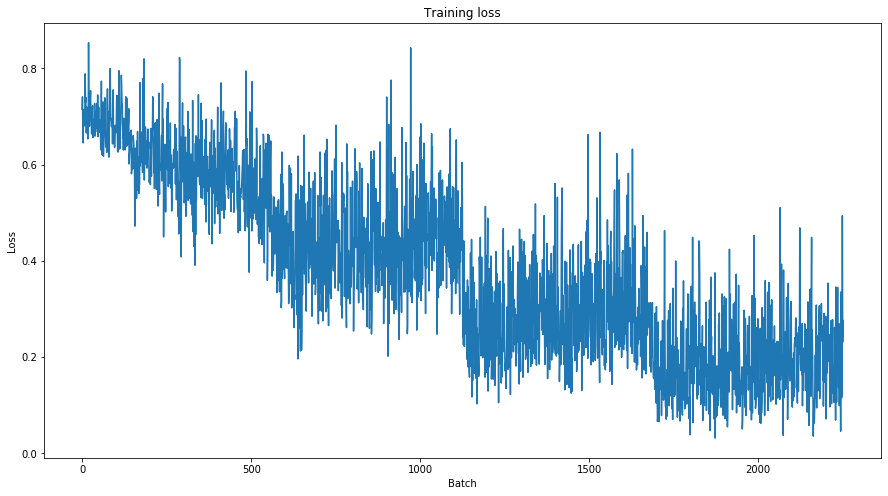

In [0]:
import matplotlib.pyplot as plt
% matplotlib inline

# Plot the loss per batch
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

## EVALUATION: Model Trial for Prediction Test.

Now that the model is trained, we need to test it on unseen data.

The step is pretty much similar to the above in term of extracting the input data.

However in order to make the prediction of each line for the non-sense and the sense sentence, we have to make the prediction as sson as the the line is ready and not on the full dataset as we have done for the training.

Therefore after reading the line, the data is prepared in the dataloader and then feed to the trained model which compute the logits and make its prediction.

In [0]:
from google.colab import drive

drive.mount('/content/drive')

# Read the unseen data for prediction.
df_trial = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP_Assignment_2/Trial Data/Trial Data/taskA_trial_data.csv', index_col=0, names=['id', 'sent0', 'sent1'], skiprows=1 )
df_trial_result = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP_Assignment_2/Trial Data/Trial Data/taskA_trial_answer.csv', index_col=0, names=['id', 'result'] )

# Array of true label : it needs to be compared with the predicted value
pred_label = []

# Array of the predicted values for each line
predictions = []

for i in range(len(df_trial.index.tolist())):
  prediction_set = []
  label_set = []

  # Load the 2 sentences of the line
  sentence0 = df_trial.sent0.values[i]
  sentence1 = df_trial.sent1.values[i]
  
  # # Tokenize them through the Bert tokenizer initialized earlier
  tokenize_pred0 = tokenizer.tokenize('[CLS] '+sentence0+' [SEP]')
  tokenize_pred1 = tokenizer.tokenize('[CLS] '+sentence1+' [SEP]')

  # Append processed sentence in prediction_set
  prediction_set.append(tokenizer.convert_tokens_to_ids(tokenize_pred0))
  prediction_set.append(tokenizer.convert_tokens_to_ids(tokenize_pred1))

  # Append the true value/label of the sentence 
  pred_label.append(int(df_trial_result.result.values[i])) 

  # append the classification label in label_set
  if int(df_trial_result.result.values[i]) == 0:
    label_set.append(1)
    label_set.append(0)
  else:
    label_set.append(0)
    label_set.append(1)
  
  # The input data are padded
  pad_prediction_set = pad_sequences(prediction_set, maxlen=max_len, dtype="long", truncating="post", padding="post")
  
  # Filter mask has to be created to differentiate tokens from padding and from sentence
  filter_set = np.array(pad_prediction_set)
  filter_set[filter_set>0] = 1
  filter_set = filter_set.astype(float).tolist()

  # format input data to torch dataloader 
  pred_tensor = torch.tensor(pad_prediction_set)
  pred_labels_tensor = torch.tensor(label_set)
  pred_filter_tensor = torch.tensor(filter_set)
  pred_data = TensorDataset(pred_tensor, pred_filter_tensor, pred_labels_tensor)
  pred_sampler = RandomSampler(pred_data)
  pred_dataloader = DataLoader(pred_data, sampler=pred_sampler, batch_size=2)

  # the model is on eval mode
  bertClassmodel.eval()

  # no grad is computed or stored
  with torch.no_grad():
    # Feed inputs to the model
    logits = bertClassmodel(pred_tensor.to(device), token_type_ids=None, attention_mask=pred_filter_tensor.to(device))
  
  # Extract the result from the model
  logits = logits.detach().cpu().numpy()
  pred_sent0 = logits[0]
  pred_sent1 = logits[1]

  # Compute the prediction of the non-sense sentence
  if max(pred_sent0) > max(pred_sent1):
    big = np.argmax(pred_sent0)
    if big == 1:
        sent_pred = 0
    else:
        sent_pred = 1
  else:
    big = np.argmax(pred_sent1)
    if big == 1:
        sent_pred = 1
    else:
        sent_pred = 0
  # Append the result of the prediction 
  predictions.append(sent_pred)

# Calculate the overall accuracy
acc = np.sum(np.array(predictions) == np.array(pred_label))/len(pred_label)
print("Prediction Accuracy: " + str(acc))








Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Prediction Accuracy: 0.9203364670954973


## Part 1: Evaluation conclusion

We can reach with our fine-tuned bert model to a very high accuracy of 0.92. 
Different approach could have been done such as using VGG16 model or ULMFiT. But is would be very unlikely that we will reach this level of score.


In [0]:

# Store the result of the prediction 
f = open('/content/drive/My Drive/Colab Notebooks/NLP_Assignment_2/Part_1_BERT_trial_result.txt', 'w+')

num=1
for p in predictions:
  f.write(str(num) + ', ' + str(p) + '\n')
  num += 1
f.close()


## Part 2

In this part we will try to detect the key reason why a sentence does not make sense. For that, we will use again the same pretrained BERT (Biderectional Encoder Representations from Transformers) Calssifier.

To start, we will load the dataset which will be used to train our BERT model. The dataset has a dimension of 10,000x4: We have indeed 10,000 lines of 4 sentences. Among the last 3 setences, we have to determine which explains the non-sense of the 1st sentences.

The dataset is present in csv format. The subTaskB_data_all.csv has 5 columns:
* *id*: The data id
* *FalseSent*: The non-sense sentence
* *A*: The 1st explanation sentence for the non-sense sentence
* *B*: The 2nd explanation sentence for the non-sense sentence
* *C*: The 3rd explanation sentence for the non-sense sentence

The subTaskB_answer_all.csv has 2 columns:
* *id*: The data id
* *result*: The sentence letter which explains correctly the non sense sentence.

In our programme, we will load those csv files in dataframe format.


In [0]:
from google.colab import drive
import pandas as pd
import numpy as np
import io

# Disk mount
drive.mount('/content/drive')

# Load the csv files of the data as well as of the results into df format
df_trainB = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP_Assignment_2/Training  Data/Training  Data/subtaskB_data_all.csv', index_col=0, names=['id', 'FalseSent', 'A', 'B', 'C'], skiprows=1 )
df_resultB = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP_Assignment_2/Training  Data/Training  Data/subtaskB_answers_all.csv', index_col=0, names=['id', 'result'])


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Data Preparation

In this phase, we will install the pretrained bert which will serve for our model building and we also transform the dataset to get vectors the data and labels . 

In [0]:
pip install pytorch_pretrained_bert

     |████████████████████████████████| 133kB 2.8MB/s 
     |████████████████████████████████| 645kB 45.5MB/s 


In [0]:
from pytorch_pretrained_bert import BertTokenizer, BertConfig
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 6018886.56B/s]


In the code below, we are preparing and tranforming the dataset for our model inputs. Indeed, the senences in the data cannot be used as it is. We should:
1. Determine the correct and wrong explanations for the non-sense sentence.
1. Tokenize the sentence: During the process, we can note below that we use special symboles to use as a separator. Typically, for the begining of a sentence use '[CLS]' and for the end , we use '[SEP]'. Moreover as we need to explain the non-sense of the 1st sentence, we can add some extra words such as 'it is not possible that \<non-sense sentence\> because \<explanation\>'
1. Convert each tokens into ids: This id is used to identified each tokens
1. The processed sentence has to be appended in a list. The labels is also appended into another list.

In [0]:
import sys
sys.setrecursionlimit(31000)
from string import punctuation

# training_set will be our input vector of data containing tokenized sentence
training_setB = []
# label_set will be our input vector of label containing the value (1 or 0): 1 is the correct explanation and 0 the wrong explanation.
label_setB = []
# the 3 Possible explanation 
answers_set= ['A', 'B', 'C']

# max sentence lenght from our dataset
max_len = 0

#The loop will go through each line (10,000 lines) and store the data and labels in their respective vectors 
for i in df_resultB.index.tolist():
  # Determine the correct sentence explanation
  answers_set_tmp = answers_set[:]
  correct_reason = df_resultB.values[i][0]
  answers_set_tmp.remove(correct_reason)

  # Store the correct explanation in a variable
  correct_str_eval = 'df_trainB.' + correct_reason + '.values' + '[' + str(i) + ']' + '.lower()'
  # Tokenize it
  tokenize_correct_reason = tokenizer.tokenize('[CLS] '+"It is not possible that " +df_trainB.values[i][0].rstrip(punctuation) + ' because ' +eval(correct_str_eval)+' [SEP]')
  # Append processed sentence in training_set and label in label_set
  training_setB.append(tokenizer.convert_tokens_to_ids(tokenize_correct_reason))
  label_setB.append(1)

  # Now for all the wrong explanation
  for j in range(len(answers_set_tmp)):
    # Store the wrong explanation in a variable
    wrong_str_eval = 'df_trainB.' + answers_set_tmp[j] + '.values' + '[' + str(i) + ']'
    if type(eval(wrong_str_eval)) is str:
      # Tokenize it
      tokenize_wrong_reason = tokenizer.tokenize('[CLS] '+"It is not possible that " +df_trainB.values[i][0].rstrip(punctuation) + ' because ' +eval(wrong_str_eval + '.lower()')+' [SEP]')
      # Append processed sentence in training_set and label in label_set
      training_setB.append(tokenizer.convert_tokens_to_ids(tokenize_wrong_reason))
      label_setB.append(0) 

      # Max sentence length in the dataset is also recorder (it will be used for padding)
      max_len = max(max_len, len(tokenize_correct_reason), len(tokenize_wrong_reason))


## Training Preparation

In this phase, the data from the dataset is extracted and prepared. Now we need to create proper input data for our model. This is the reason of this phase.

Below, all the sentence does not have the same length in order to avoid errors while processing the input data vectors during the training phase.

In [0]:
from keras.preprocessing.sequence import pad_sequences
# The input data are padded to longest sentence in the dataset (max_len)
max_len = max_len+20
pad_training_set = pad_sequences(training_setB, maxlen=max_len, dtype="long", truncating="post", padding="post")

Using TensorFlow backend.


Creating the mask is also necessary after doing the imput data padding.
Indeed, the reason is that we need to figure out from the padded input sentence which are the meainingful tokens (tokens from the sentence) and which are from the padding.

In short, the position of all the meaningful tokens will be set to 1 for the mask whereas the position of padding tokens will be set to 0.

In [0]:
# Filter mask has to be created to differentiate tokens from padding and from sentence
filter_set = np.array(pad_training_set)
filter_set[filter_set>0] = 1
filter_set = filter_set.astype(float).tolist()

Below, we split the dataset into the training dataset and the validation dataset. The objective is to train the training dataset and use a partof the dataset to control and evaluate the training model as a validation part of the model.

In [0]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split our data into train and validation sets for training
train_inputs, val_inputs, train_labels, val_labels = train_test_split(pad_training_set, label_setB, random_state=112, test_size=0.1)
train_filter, val_filter, _, _ = train_test_split(filter_set, pad_training_set, random_state=112, test_size=0.1)

Now, we should format the input into torch data in order to feed the model with the apprpriate format.

In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Batch size selection for training our model
batch_size = 32

## Training data
# With torch DataLoader we create an iterator fro our model.
train_tensor = torch.tensor(train_inputs)
train_labels_tensor = torch.tensor(train_labels)
train_filter_tensor = torch.tensor(train_filter)
train_data = TensorDataset(train_tensor, train_filter_tensor, train_labels_tensor)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)



In [0]:

## Validation data
# With torch DataLoader we create an iterator fro our model.
val_tensor = torch.tensor(val_inputs)
val_labels_tensor = torch.tensor(val_labels)
val_filter_tensor = torch.tensor(val_filter)
val_data = TensorDataset(val_tensor, val_filter_tensor, val_labels_tensor)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

## Bert Model Construction

In this phase, all our data is already ready: We need now to build our Bert model.

Below, we choose a bert Classifier since we need to determine which sentence does not make sense. Note that we set the base as 'bert-base-uncased' which means that we are working on case insensitive base.

In [0]:
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification

# we use the BertForSequenceClassification. This is a pretrained model with a classification layer at the end. 
bertClassmodelB = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
bertClassmodelB.cuda()

100%|██████████| 407873900/407873900 [00:06<00:00, 58644127.34B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

Below, we are tuning the paramaters of or Bert pretrained model in order to smoothen the decay-rate: It is a fine-tuning of the Bert Model, therefore we need to set low rate for the decay but also for the learning (lr: learning rate)

In [0]:

all_parameters = list(bertClassmodelB.named_parameters())

# We are fine tuning the Bert pretrained model to avoid to radical learning change.
all_parameters_set = [
    {'params': [param for name, param in all_parameters if not any(n in name for n in ['bias', 'gamma', 'beta'])], 'weight_decay_rate': 0.01},
    {'params': [param for name, param in all_parameters if any(n in name for n in ['bias', 'gamma', 'beta'])], 'weight_decay_rate': 0.0}
]

# The learning rate here is set to 1.5e-5
opti = BertAdam(all_parameters_set, lr=1.5e-5, warmup=.1)

t_total value of -1 results in schedule not being applied


## Fine-Tuning training Model.

This the important part of the code: The model and the data are ready. We need now to feed the pretrained model with the input data. With the smooth learning rate and weight_decay_rate, we pretrained model will just change a bit to adapt with the new training input data.

Below, the code is divided into 2 sections: One for the model training and another one for the validation. 
Here are the steps for the training part:
* The model is set into train mode
* the data, the label and the mask are extracted and set from the dataloader
* The previous calculated gradient is cleared (opti.zero_grad())
* The input data is given to the model which compute the loss
* Back propagation of the result
* Update the parameters (opti.step())

As for the validation part, the steps are:
* The model is set into eval mode
* the validatio data and the mask are extracted and set from the dataloader
* The input data is given to the model which return the logits value


In [0]:
from tqdm import tqdm, trange
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# the loss is stored for plotting
train_loss_set = []

# Number of epoch
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  ### Training phase
  
  # The model is on training mode
  bertClassmodelB.train()
  
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # the data is trained
  for step, batch in enumerate(train_dataloader):
    # extract inputs from dataloader
    b_input_ids = batch[0].to(device)
    b_input_mask= batch[1].to(device)
    b_labels = batch[2].to(device)
    # The previous computed gradient is cleared
    opti.zero_grad()
    # Forward pass
    loss = bertClassmodelB(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update the gradient 
    opti.step()
    
    
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  ### Validation phase

  # The model is on evaluation mode
  bertClassmodelB.eval()

  tot_accuracy = 0
  tot_steps = 0

  # Evaluate data for one epoch
  for batch in val_dataloader:
    # extract inputs from dataloader
    b_input_ids = batch[0].to(device)
    b_input_mask= batch[1].to(device)
    b_labels = batch[2].to(device)
    # The model will not store or compute gradient
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = bertClassmodelB(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_pred = np.argmax(logits, axis=1).flatten()
    label_val = label_ids.flatten()
    tmp_accuracy = np.sum(tmp_pred == label_val) / len(label_val)
    
    tot_accuracy += tmp_accuracy
    tot_steps += 1

  print("Validation Accuracy: {}".format(tot_accuracy/tot_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.41344651768769697


Epoch:  25%|██▌       | 1/4 [14:00<42:00, 840.21s/it]

Validation Accuracy: 0.8436391843971631
Train loss: 0.255696108489699


Epoch:  50%|█████     | 2/4 [28:09<28:06, 843.07s/it]

Validation Accuracy: 0.8412012411347518
Train loss: 0.1408980961964064


Epoch:  75%|███████▌  | 3/4 [42:19<14:04, 844.89s/it]

Validation Accuracy: 0.8433067375886524
Train loss: 0.0720284254956655


Epoch: 100%|██████████| 4/4 [56:28<00:00, 846.33s/it]

Validation Accuracy: 0.84375


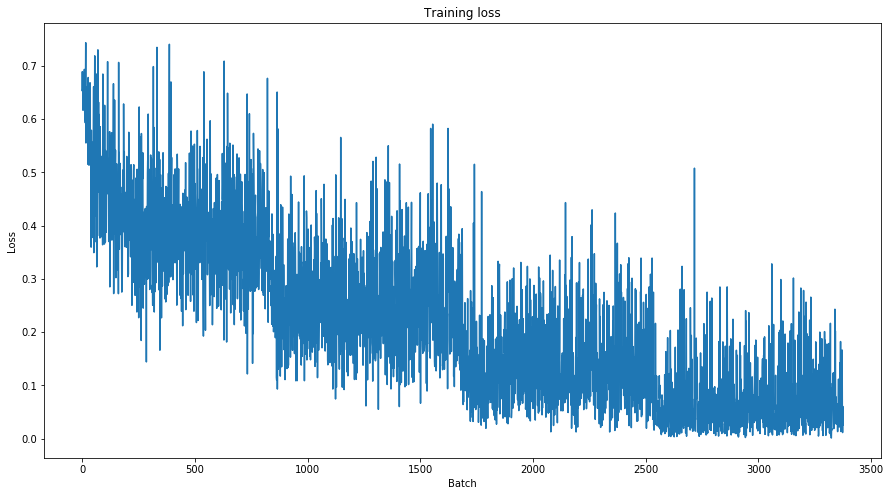

In [0]:
import matplotlib.pyplot as plt
% matplotlib inline

# Plot the loss per batch
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

## EVALUATION: Model Trial for Prediction Test.

Now that the model is trained, we need to test it on unseen data.

The step is pretty much similar to the above in term of extracting the input data.

However in order to make the prediction of each line for the non-sense and the sense sentence, we have to make the prediction as sson as the the line is ready and not on the full dataset as we have done for the training.

Therefore after reading the line, the data is prepared in the dataloader and then feed to the trained model which compute the logits and make its prediction.

In [0]:
from google.colab import drive
from string import punctuation

drive.mount('/content/drive')

# Read the unseen data for prediction.
df_trialB = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP_Assignment_2/Trial Data/Trial Data/taskB_trial_data.csv', index_col=0, names=['id', 'FalseSent', 'A', 'B', 'C'], skiprows=1 )
df_trial_resultB = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP_Assignment_2/Trial Data/Trial Data/taskB_trial_answer.csv', index_col=0, names=['id', 'result'] )

# Array of the predicted values for each line
predictions = []
# Array of the predicted values for each line
pred_label = []

# the 3 Possible explanation 
answers_set= ['A', 'B', 'C']


for i in range(len(df_trialB.index.tolist())):
  prediction_set = []
  label_set = []
  # For each possible answer
  for ans in answers_set:
    # ... If it is the correct explanation
    if ans == df_trial_resultB.values[i][0]:
      # Determine the correct sentence explanation
      correct_reason = df_trial_resultB.values[i][0]
      correct_str_eval = 'df_trialB.' + correct_reason + '.values' + '[' + str(i) + ']'+ '.lower()'
      # tokenize it
      tokenize_correct_reason = tokenizer.tokenize('[CLS] '+"It is not possible that " +df_trialB.values[i][0].rstrip(punctuation) + ' because ' +eval(correct_str_eval)+' [SEP]')
      # Append processed sentence in prediction_set input and label in label_set
      prediction_set.append(tokenizer.convert_tokens_to_ids(tokenize_correct_reason))
      label_set.append(1)
      # Store the real label for accuracy calculation 
      pred_label.append(correct_reason)
    else:
      # ... In case of the wrong explanation, determine the sentence
      wrong_str_eval = 'df_trialB.' + ans + '.values' + '[' + str(i) + ']'
      # Check if it is a string
      if type(eval(wrong_str_eval)) is str:
        # Tokenize it 
        tokenize_wrong_reason = tokenizer.tokenize('[CLS] '+"It is not possible that " +df_trialB.values[i][0].rstrip(punctuation) + ' because ' +eval(wrong_str_eval+ '.lower()')+' [SEP]')
        # Append processed sentence in prediction_set input and label in label_set
        prediction_set.append(tokenizer.convert_tokens_to_ids(tokenize_wrong_reason))
        label_set.append(0)
      else:
        # Tokenize it and leave the explanation empty as the reis no string
        tokenize_wrong_reason = tokenizer.tokenize('[CLS] '+"It is not possible that " +df_trialB.values[i][0].rstrip(punctuation) + ' because ' + '' +' [SEP]')
        # Append processed sentence in prediction_set input and label in label_set
        prediction_set.append(tokenizer.convert_tokens_to_ids(tokenize_wrong_reason))
        label_set.append(0)
  
  # The input data are padded
  pad_prediction_set = pad_sequences(prediction_set, maxlen=max_len, dtype="long", truncating="post", padding="post")
  
  # Filter mask has to be created to differentiate tokens from padding and from sentence
  filter_set = np.array(pad_prediction_set)
  filter_set[filter_set>0] = 1
  filter_set = filter_set.astype(float).tolist()

  # format input data to torch dataloader 
  pred_tensor = torch.tensor(pad_prediction_set)
  pred_labels_tensor = torch.tensor(label_set)
  pred_filter_tensor = torch.tensor(filter_set)
  pred_data = TensorDataset(pred_tensor, pred_filter_tensor, pred_labels_tensor)
  pred_sampler = RandomSampler(pred_data)
  pred_dataloader = DataLoader(pred_data, sampler=pred_sampler, batch_size=batch_size)
  
  # the model is on eval mode
  bertClassmodelB.eval()
  # no grad is computed or stored
  with torch.no_grad():
    # Feed inputs to the model
    logits = bertClassmodelB(pred_tensor.to(device), token_type_ids=None, attention_mask=pred_filter_tensor.to(device))
  
  # Extract the result from the model
  logits = logits.detach().cpu().numpy()
  pred_sentA = logits[0]
  pred_sentB = logits[1]
  pred_sentC = logits[2]

  # Compute the prediction of the non-sense sentence
  tmp_list = [pred_sentA.tolist()[1], pred_sentB.tolist()[1], pred_sentC.tolist()[1]]
  ind = tmp_list.index(max(tmp_list))
  if ind == 0:
    predictions.append('A')
  elif ind == 1:
    predictions.append('B')
  else:
    predictions.append('C')
# Calculate the overall accuracy
acc = np.sum(np.array(predictions) == np.array(pred_label))/len(pred_label)
print("Prediction Accuracy: " + str(acc))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Prediction Accuracy: 0.9005442850074221


## Part 2: Evaluation conclusion

We can reach with our fine-tuned bert model to a very high accuracy of 0.90. 
This score is very high and it could be very difficult ta reach to a higher score than this.

In [0]:
f = open('/content/drive/My Drive/Colab Notebooks/NLP_Assignment_2/Part_2_BERT_trial_result.txt', 'w+')

num=1
for p in predictions:
  f.write(str(num) + ', ' + str(p) + '\n')
  num += 1
f.close()


# PART 3

In this part we will try to generate an explanation for a non-sense sentence . For that, we will use another model the pretrained GPT-2 (Generative Pretrained Transformer 2). The simplified version of the model will be used since the complete version model is not available due to ethical reason. 

To start, we will load the dataset which will be used to train our GPT2 model. The dataset has a dimension of 10,000x1: We have indeed 10,000 lines of 1 non-sense sentence and we have to generate an explanation of the non-sense sentence.

The dataset is present in csv format. The subTaskC_data_all.csv has 2 columns:
* *id*: The data id
* *FalseSent*: The non-sense sentence

The subTaskC_answer_all.csv has 4 columns:
* *id*: The data id
* *reason1*: The 1st explanation for the non sense sentence
* *reason2*: The 2nd explanation for the non sense sentence
* *reason2*: The 3rd explanation for the non sense sentence

In our programme, we will load those csv files in dataframe format.


In [0]:
from google.colab import drive
import pandas as pd
import numpy as np

drive.mount('/content/drive')

df_trainC = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP_Assignment_2/Training  Data/Training  Data/subtaskC_data_all.csv', index_col=0, names=['id', 'FalseSent'], skiprows=1 )
df_resultC = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP_Assignment_2/Training  Data/Training  Data/subtaskC_answers_all.csv', index_col=0, names=['id', 'reason1', 'reason2', 'reason3'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## GPT-2 Model Construction

In this phase, we will install the GPT-2 simplified pretrained model.

Below, we choose the simpliest GPT-2 model the "124M"

In [0]:
# GPT-2 installation
!pip install -q gpt-2-simple
import gpt_2_simple as gpt2



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
# Download the "124M" model 
gpt2.download_gpt2(model_name="124M")

Fetching checkpoint: 1.05Mit [00:00, 566Mit/s]                                                      
Fetching encoder.json: 1.05Mit [00:00, 107Mit/s]                                                    
Fetching hparams.json: 1.05Mit [00:00, 486Mit/s]                                                    
Fetching model.ckpt.data-00000-of-00001: 498Mit [00:02, 167Mit/s]                                   
Fetching model.ckpt.index: 1.05Mit [00:00, 350Mit/s]                                                
Fetching model.ckpt.meta: 1.05Mit [00:00, 160Mit/s]                                                 
Fetching vocab.bpe: 1.05Mit [00:00, 169Mit/s]                                                       


In [0]:
# We mount the google drive disk
gpt2.mount_gdrive()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Preparation

In the code below, we are preparing and tranforming the dataset for our model input. Here are the step done:
1. Read the non-sense sentence and remove the punctuation at the end.
1. Create new sentence with the non-sense sentence + the 3 reasons from the result dataframe : 3 sentences will be created with the causality effect. Typically, we will have sentences like 'it is not possible that \<non-sense sentence\> because \<explanation\>'
1. Write those sentences in a file: Indeed in the simplified GPT-2 model the input should be a file.

In [0]:
import sys
from string import punctuation
sys.setrecursionlimit(31000)

# Create a file to dump a sentences model input for our GPT-2 model
f = open('/content/drive/My Drive/Colab Notebooks/NLP_Assignment_2/Part_3_BERT_train_sentences.txt', 'w+')

# Going through each line
for i in df_resultC.index.tolist():
  # Read the non-sense sentence and remove end punctuation and set it to lower case
  false_sentence = df_trainC.values[i][0]
  false_sentence = false_sentence.rstrip(punctuation)
  false_sentence = false_sentence.lower()

  # Going through each reason specified in the result df.
  for j in ['reason1', 'reason2', 'reason3']:
    # Read the reason and set to lower case
    reason_sentence = 'df_resultC.' + j + '.values' + '[' + str(i) + ']'
    reason_sentence = eval(reason_sentence)
    reason_sentence = reason_sentence.lower()

    # Write the new created sentence with causality in the file
    f.write('It is not possible that ' + false_sentence +' because ' + reason_sentence + '\n')
f.close()

## Fine-Tuning training Model.

This the important part of the code: The model and the data are ready. We need now to feed the pretrained the GPT-2 model with the input data. The usage of the model for training is straight forward :
1. We create our model: gpt2_model
1. Then, we just need to fill some options for our model as inputs

Below, here are the explanation of the option used:
* *gpt2_model*: The name of the model to trained (the one created)
* *model_name*: The model pretrained database used 
* *restore_from*: Here we use fresh since we don't have a restore point
* *run_name*: subfolder with checkpoint to save the model eventually
* *print_every*: display the training progress after some specified steps
* *sample_every*: Provide some example of sentences based on the training


In [0]:
train_file = '/content/drive/My Drive/Colab Notebooks/NLP_Assignment_2/Part_3_BERT_train_sentences.txt'

gpt2_model = gpt2.start_tf_sess()

gpt2.finetune(gpt2_model,
              dataset=train_file,
              model_name='124M',
              steps=1000,
              restore_from='fresh',
              run_name='run1',
              print_every=10,
              sample_every=200,
              save_every=500
              )


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Loading checkpoint models/124M/model.ckpt
INFO:tensorflow:Restoring parameters from models/124M/model.ckpt


  0%|          | 0/1 [00:00<?, ?it/s]

Loading dataset...


100%|██████████| 1/1 [00:03<00:00,  3.70s/it]


dataset has 733955 tokens
Training...
[10 | 18.20] loss=1.50 avg=1.50
[20 | 30.70] loss=1.46 avg=1.48
[30 | 43.15] loss=1.33 avg=1.43
[40 | 55.62] loss=1.38 avg=1.42
[50 | 68.09] loss=1.36 avg=1.40
[60 | 80.54] loss=1.19 avg=1.37
[70 | 93.01] loss=1.39 avg=1.37
[80 | 105.48] loss=1.32 avg=1.37
[90 | 117.93] loss=1.31 avg=1.36
[100 | 130.40] loss=1.33 avg=1.36
[110 | 142.91] loss=1.41 avg=1.36
[120 | 155.38] loss=1.27 avg=1.35
[130 | 167.84] loss=1.33 avg=1.35
[140 | 180.30] loss=1.26 avg=1.34
[150 | 192.77] loss=1.21 avg=1.34
[160 | 205.27] loss=1.25 avg=1.33
[170 | 217.76] loss=1.36 avg=1.33
[180 | 230.28] loss=1.29 avg=1.33
[190 | 242.76] loss=1.33 avg=1.33
[200 | 255.23] loss=1.27 avg=1.33
======== SAMPLE 1 ========
 customers cannot be sold on the internet.
It is not possible that you can eat meat in the supermarket because people do not eat meat in the supermarket.
It is not possible that you can eat meat in the supermarket because it is not acceptable to eat meat in the supermark

## Model Trial: Text generation.

Now that the model is trained, we need to test it based on new inputs.

We first read the taskC_trial_data file and we prepare the input sentence just like we did for the training data.

Then we use : gpt2.generate function to feed it with the prepared sentence. Some option are used

Here are the explanation of the options:
* *length*: The number of generated tokens (text length)
* *temperature*: The higher is the temperature the more innovative the model will be
* *prefix*: the text which is feed to the model as a sart to generate its sentence 
* *nsamples*: number of text generated based on the prefix. Here we are generating 3 sentences with the same prefix
* *retrun_as_list*: By default, the model print in the output. But if this option is activated then it stores the generated text in a given variable.

In [0]:
df_trialC = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP_Assignment_2/Trial Data/Trial Data/taskC_trial_data.csv', index_col=0, names=['id', 'FalseSent'], skiprows=1 )

In [0]:
import sys
from string import punctuation

# List to append the result of GPT2 model generated text
gen_all_sentences=[]
for i in range(len(df_trialC.index.tolist())):
  # Read the non-sense sentence and remove end punctuation and set it to lower case
  false_sentence = df_trialC.values[i][0]
  false_sentence = false_sentence.rstrip(punctuation)
  false_sentence = false_sentence.lower()  

  # Use the model to generate text and store in the variable
  gen_all_sentences.append(gpt2.generate(gpt2_model,
              length=15,
              temperature=0.7,
              prefix="It is not possible that " + false_sentence +' because ',
              nsamples=3,
              batch_size=3,
              return_as_list=True
              ))
 

## Text generation Post-processing.

Since the genreated text does not stop at a proper punctuation, we need to post process the text to remove uncompleted phrases which are generated in extra. 

Moreover, we will save the generated text in 2 files:
* Part_3_BERT_trial_generated_sentences.txt: which will store the genreted sentences of the gpt2 model
* Part_3_BERT_trial_generate_solution.csv: which is a csv file which for each line you have 3 generated reasons for the non-sense sentence. 

In [0]:
import re

# 2 files for writing the output of the gpt2 model 
f1 = open('/content/drive/My Drive/Colab Notebooks/NLP_Assignment_2/Part_3_BERT_trial_generated_sentences.txt', 'w+')
f2 = open('/content/drive/My Drive/Colab Notebooks/NLP_Assignment_2/Part_3_BERT_trial_generate_solution.csv', 'w+')

# post processing to remove uncompleted sentence: we will get proper sentences which will be stored in Part_3_BERT_trial_generated_sentences.txt
gen_sentence2 = [list(map(lambda y:re.sub('\n.*', '', y),x)) for x in gen_all_sentences ]
#post processing to extract only the reason/explanation of the non-sense sentence which will be stored in Part_3_BERT_trial_generate_solution.csv
gen_sentence3 = [list(map(lambda y:re.sub('It is not possible that\s+.*\s+because\s+(.*)', r'\1', y),x)) for x in gen_sentence2 ]

# writing files
num=1
for (i,j) in zip(gen_sentence2,gen_sentence3):
  for k in i:
    f1.write(str(num) + ', ' + k + '\n')
  f2.write(str(num) + ', ' + ','.join(j) + '\n')
  num += 1

f1.close()
f2.close()